# Machine learning : Xente project

The goal of this project is to be able to predict whether some transactions are fraudulent or not. The job of the model will be to estsablish a classification of a set of transactions in the most accurate way possible.

## Looking at dataset and preparing data

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
train_data = pd.read_csv('data/training.csv')
test_data = pd.read_csv('data/test.csv')


# Separate target from predictors
y = train_data.FraudResult
X = train_data.drop(['FraudResult'], axis=1)

transaction_test_ids = test_data.pop('TransactionId')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                           random_state=0)


X_train.head(5)


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
66339,TransactionId_140085,BatchId_114864,AccountId_4841,SubscriptionId_3829,CustomerId_4827,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-01-20T16:21:05Z,2
87279,TransactionId_64558,BatchId_39429,AccountId_3981,SubscriptionId_910,CustomerId_4431,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-06T18:25:51Z,4
40582,TransactionId_134904,BatchId_1673,AccountId_135,SubscriptionId_3595,CustomerId_457,UGX,256,ProviderId_6,ProductId_21,utility_bill,ChannelId_3,15000.0,16650,2018-12-26T04:17:14Z,2
58655,TransactionId_95030,BatchId_133112,AccountId_4840,SubscriptionId_3829,CustomerId_582,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2019-01-12T15:57:39Z,2
87335,TransactionId_75383,BatchId_7649,AccountId_4841,SubscriptionId_3829,CustomerId_3328,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-06T19:05:15Z,2


# Dataset observations

In [70]:
train_data.size
print(f"{train_data.axes[0].size} observations")
print(f"{train_data.axes[1].size -1 } features")

95662 observations
15 features


In [71]:
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]
print(cols_with_missing)

#No missing fields in the dataset, therefore we will not need to handle imputation in this project.

[]


### Looking at our classes proportions

In [72]:

not_fraud = train_data[train_data.FraudResult==0].FraudResult
fraud = train_data[train_data.FraudResult==1].FraudResult
print(f"{(not_fraud.size/(fraud.size+not_fraud.size))*100} % of the transactions are non fraudulent")

99.79824799816019 % of the transactions are non fraudulent


As we can see, we have a very highly imbalanced dataset. In those cases, we can be really though to make a good learning process. We will then have to deal with some oversampling or downsampling techniques.   

In [73]:
print(len(train_data[train_data.FraudResult==0]))
print(len(train_data[train_data.FraudResult==1]))

95469
193


In all our observations at our disposal to perform a good learning, we only have 193 of them that are fraudulent. Here, the downsampling option will probably not be appropriated because we would have a very small training data set.

# Mutual information

Mutual information will be useful to identify the relative importance of each features to determine the fraud result. This analysis will give a good overview of the principal features that will be potentially more important than some others. 

In [74]:
from sklearn.feature_selection import mutual_info_classif

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [75]:
# copied from  kaggle course
def make_mi_scores(new_X, new_y, discrete_features):
    mi_scores = mutual_info_classif(new_X, new_y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=new_X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [76]:
# Label encoding for categoricals

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
discrete_features = X.dtypes == int


*To perform mutual information, we need to specify weather our features are discrete or not since this scikit-learn algorithm treats discrete features differently from continuous features

In [77]:
X_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
66339,TransactionId_140085,BatchId_114864,AccountId_4841,SubscriptionId_3829,CustomerId_4827,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-01-20T16:21:05Z,2
87279,TransactionId_64558,BatchId_39429,AccountId_3981,SubscriptionId_910,CustomerId_4431,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-06T18:25:51Z,4
40582,TransactionId_134904,BatchId_1673,AccountId_135,SubscriptionId_3595,CustomerId_457,UGX,256,ProviderId_6,ProductId_21,utility_bill,ChannelId_3,15000.0,16650,2018-12-26T04:17:14Z,2
58655,TransactionId_95030,BatchId_133112,AccountId_4840,SubscriptionId_3829,CustomerId_582,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2019-01-12T15:57:39Z,2
87335,TransactionId_75383,BatchId_7649,AccountId_4841,SubscriptionId_3829,CustomerId_3328,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-06T19:05:15Z,2


In [78]:
mi_scores = make_mi_scores(X, y, discrete_features)

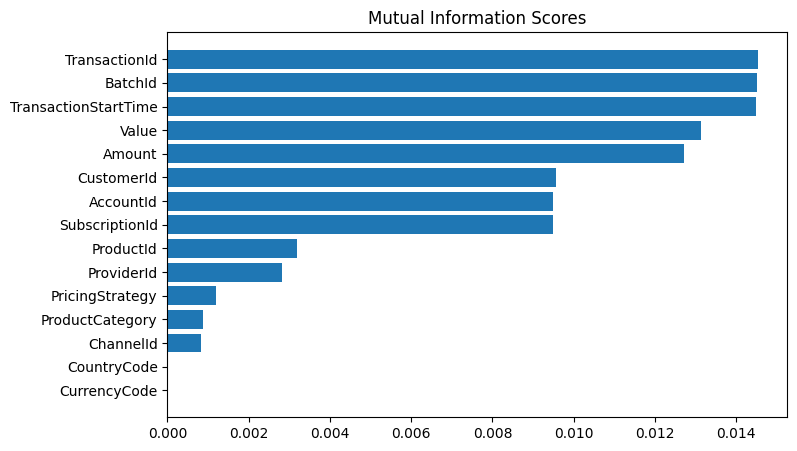

In [79]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

As a result of this analysis, we can now see on this plot that should maybe train our model arround these top 5 features : TransactionId , BatchId, TransactionStartTime, Value, Amount. 
<br/>
<br/>
But actually, features we want to focus on are those that will have the highest probably to appear again in future transactions since the test data should be quite similar to future transactions. Therefore, features like the TransactionId or BatchId will be totally useless and maybe even confusing for the model since those types of features are unique, they have no chance at all to appear again in the test dataset.
This means that the feature will maybe detect a pattern about the TransactionId that he will not be able to find in a test set. In those situtations, we are exposing our model to some possible overfitting which is a big problem that will leed to poor performance on some new observations (unseen from our model during the learning phase).
<br>
<br>
The features that might be more relevant are for example the TransactionStartTime, the Value, ProductId or ProductCategory because these elements have chances to appear in the test data. 




# Initial preprocessing

In [80]:
underscore_columns = ['BatchId','AccountId','SubscriptionId','CustomerId','ProviderId','ProductId','ChannelId']#'TransactionId'


for cname in X_train.columns:
    if cname in underscore_columns:
        train_number = X_train[cname].str.split('_').str[1]
        valid_number = X_valid[cname].str.split('_').str[1]
        test_number = test_data[cname].str.split('_').str[1]
        X_train[cname] =  train_number
        X_valid[cname] = valid_number
        test_data[cname] = test_number


*In the beginning, i have tried using the pervious 'underscore_columns' so i had to turn them to discrete variables in order to use SMOTE.  

In [81]:
X_train.CurrencyCode.value_counts()
X_train.CountryCode.value_counts()

CountryCode
256    76529
Name: count, dtype: int64

For both CountryCode and CurrencyCode, we can see that all observations have the same values. Therefore there is for our training set no informations to deduce from these features. That's why i just dropped them 

In [82]:
X_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
66339,TransactionId_140085,114864,4841,3829,4827,UGX,256,4,6,financial_services,2,-50.0,50,2019-01-20T16:21:05Z,2
87279,TransactionId_64558,39429,3981,910,4431,UGX,256,5,3,airtime,3,1000.0,1000,2019-02-06T18:25:51Z,4
40582,TransactionId_134904,1673,135,3595,457,UGX,256,6,21,utility_bill,3,15000.0,16650,2018-12-26T04:17:14Z,2
58655,TransactionId_95030,133112,4840,3829,582,UGX,256,4,6,financial_services,2,-1000.0,1000,2019-01-12T15:57:39Z,2
87335,TransactionId_75383,7649,4841,3829,3328,UGX,256,4,6,financial_services,2,-50.0,50,2019-02-06T19:05:15Z,2


In [83]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [84]:
X_valid.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
69075,TransactionId_91392,117569,834,3759,1179,UGX,256,1,3,airtime,3,2000.0,2000,2019-01-23T11:50:31Z,4
65709,TransactionId_119416,24161,4127,4240,4579,UGX,256,6,10,airtime,3,1110.0,1110,2019-01-19T17:11:53Z,2
5430,TransactionId_124012,51521,190,1897,513,UGX,256,6,10,airtime,3,2000.0,2000,2018-11-22T06:34:07Z,2
82375,TransactionId_12251,126898,4840,3829,3212,UGX,256,4,6,financial_services,2,-1000.0,1000,2019-02-01T17:45:07Z,2
60896,TransactionId_27059,17843,1579,821,1956,UGX,256,6,3,airtime,3,1000.0,1000,2019-01-15T12:21:53Z,2


In [85]:
from sklearn.metrics import f1_score, recall_score,accuracy_score


def compute_imbalanced_scores(model_preds):
    f1 = f1_score(y_valid, model_preds)
    recall = recall_score(y_valid, model_preds)
    accuracy = accuracy_score(y_valid, model_preds)
    # f1 = (2*recall*accuracy)/(recall + accuracy)
    return f" Accuracy score: {accuracy} % \n F1 score: {f1} % \n Recall score: {recall} "

# Using preprocessing 

In [86]:
X_valid.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
69075,TransactionId_91392,117569,834,3759,1179,UGX,256,1,3,airtime,3,2000.0,2000,2019-01-23T11:50:31Z,4
65709,TransactionId_119416,24161,4127,4240,4579,UGX,256,6,10,airtime,3,1110.0,1110,2019-01-19T17:11:53Z,2
5430,TransactionId_124012,51521,190,1897,513,UGX,256,6,10,airtime,3,2000.0,2000,2018-11-22T06:34:07Z,2
82375,TransactionId_12251,126898,4840,3829,3212,UGX,256,4,6,financial_services,2,-1000.0,1000,2019-02-01T17:45:07Z,2
60896,TransactionId_27059,17843,1579,821,1956,UGX,256,6,3,airtime,3,1000.0,1000,2019-01-15T12:21:53Z,2


### a bit of feature engeneering

In [87]:
def create_credit_debit_cols(amount):
    if amount < 0:
        return pd.Series({'Credit': 1, 'Debit': 0})
    else:
        return pd.Series({'Credit': 0, 'Debit': 1})

In [88]:
# Apply the function to 'Amount' column to create 'Credit' and 'Debit' columns
X_train[['Credit', 'Debit']] = X_train['Amount'].apply(lambda x: create_credit_debit_cols(x))
X_valid[['Credit', 'Debit']] = X_valid['Amount'].apply(lambda x: create_credit_debit_cols(x))
test_data[['Credit', 'Debit']] = test_data['Amount'].apply(lambda x: create_credit_debit_cols(x))

In [89]:
X_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,Credit,Debit
66339,TransactionId_140085,114864,4841,3829,4827,UGX,256,4,6,financial_services,2,-50.0,50,2019-01-20T16:21:05Z,2,1,0
87279,TransactionId_64558,39429,3981,910,4431,UGX,256,5,3,airtime,3,1000.0,1000,2019-02-06T18:25:51Z,4,0,1
40582,TransactionId_134904,1673,135,3595,457,UGX,256,6,21,utility_bill,3,15000.0,16650,2018-12-26T04:17:14Z,2,0,1
58655,TransactionId_95030,133112,4840,3829,582,UGX,256,4,6,financial_services,2,-1000.0,1000,2019-01-12T15:57:39Z,2,1,0
87335,TransactionId_75383,7649,4841,3829,3328,UGX,256,4,6,financial_services,2,-50.0,50,2019-02-06T19:05:15Z,2,1,0


Breaking down the TransactionStartTime feature

In [90]:
X_train["TransactionStartTime"] = X_train["TransactionStartTime"].str.replace("Z","")     
X_valid["TransactionStartTime"] = X_valid["TransactionStartTime"].str.replace("Z","")  
test_data["TransactionStartTime"] = test_data["TransactionStartTime"].str.replace("Z","")  



X_train[["StartDate", "StartTime"]] = X_train["TransactionStartTime"].str.split("T", expand=True)     
X_valid[["StartDate", "StartTime"]] = X_valid["TransactionStartTime"].str.split("T", expand=True)  
test_data[["StartDate", "StartTime"]] = test_data["TransactionStartTime"].str.split("T", expand=True)  

X_train["StartMonth"] = X_train["StartDate"].str.split("Z").str[0].str.split('-').str[1]
X_valid["StartMonth"] = X_valid["StartDate"].str.split("Z").str[0].str.split('-').str[1]
test_data["StartMonth"] = test_data["StartDate"].str.split("Z").str[0].str.split('-').str[1]

X_train["StartDay"] = X_train["StartDate"].str.split("Z").str[0].str.split('-').str[2]
X_valid["StartDay"] = X_valid["StartDate"].str.split("Z").str[0].str.split('-').str[2]
test_data["StartDay"] = test_data["StartDate"].str.split("Z").str[0].str.split('-').str[2]

X_train["StartHour"] = X_train["StartTime"].str.split(":").str[0]
X_valid["StartHour"] = X_valid["StartTime"].str.split(":").str[0]
test_data["StartHour"] = test_data["StartTime"].str.split(":").str[0]

X_train["StartMinute"] = X_train["StartTime"].str.split(":").str[1]
X_valid["StartMinute"] = X_valid["StartTime"].str.split(":").str[1]
test_data["StartMinute"] = test_data["StartTime"].str.split(":").str[1]


# X_train = X_train.drop('TransactionStartTime',axis=1)
# X_valid= X_valid.drop('TransactionStartTime',axis=1)
# test_data= test_data.drop('TransactionStartTime',axis=1)


# feature engeneering using mutual information showed that these two columns have no impact on FraudResult
# added temporary other features starting from BatchId
useless_columns = ['TransactionId','CurrencyCode','CountryCode','TransactionStartTime','StartTime','StartDate','StartDay','StartMinute','Amount','BatchId','SubscriptionId','ChannelId','CustomerId','ProductId','ProviderId','AccountId']#'StartHour','StartMinute','StartDay'
X_train = X_train.drop(useless_columns,axis=1)
X_valid= X_valid.drop(useless_columns,axis=1)
test_data= test_data.drop(useless_columns[1:],axis=1)



In [91]:
df_train = pd.concat([X_train,y_train],axis=1)

StartMonth
01            52
12            52
02            42
11            12
Name: count, dtype: int64


<Axes: xlabel='StartMonth'>

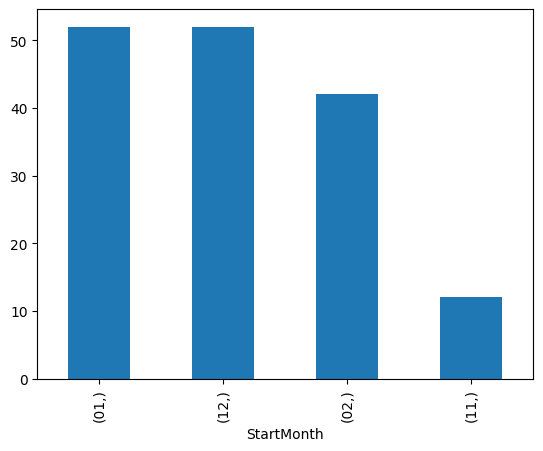

In [92]:
months_with_fraud = df_train.loc[df_train.FraudResult==1,["StartMonth"]].value_counts()
print(months_with_fraud)
months_with_fraud.plot.bar()

PricingStrategy
2                  115
0                   29
4                    9
1                    5
Name: count, dtype: int64


<Axes: xlabel='PricingStrategy'>

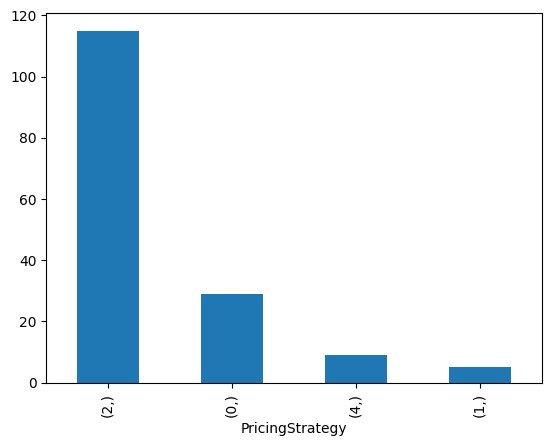

In [93]:
pricing_strategy_with_fraud = df_train.loc[df_train.FraudResult==1,["PricingStrategy"]].value_counts()
print(pricing_strategy_with_fraud)
pricing_strategy_with_fraud.plot.bar()

In [94]:
X_train.head()

,ProductCategory,Value,PricingStrategy,Credit,Debit,StartMonth,StartHour
66339,financial_services,50,2,1,0,01,16
87279,airtime,1000,4,0,1,02,18
40582,utility_bill,16650,2,0,1,12,04
58655,financial_services,1000,2,1,0,01,15
87335,financial_services,50,2,1,0,02,19


In [95]:
# # Label encoding for categoricals

# for colname in X_train.select_dtypes("object"):
#     X_train[colname], _ = X_train[colname].factorize()
# discrete_features = X_train.dtypes == int

# mi_scores = make_mi_scores(X_train, y_train, discrete_features)


In [96]:
# plt.figure(dpi=100, figsize=(8, 5))
# plot_mi_scores(mi_scores)

In [97]:
X_train.head()

,ProductCategory,Value,PricingStrategy,Credit,Debit,StartMonth,StartHour
66339,financial_services,50,2,1,0,01,16
87279,airtime,1000,4,0,1,02,18
40582,utility_bill,16650,2,0,1,12,04
58655,financial_services,1000,2,1,0,01,15
87335,financial_services,50,2,1,0,02,19


In [98]:
X_valid.head()

,ProductCategory,Value,PricingStrategy,Credit,Debit,StartMonth,StartHour
69075,airtime,2000,4,0,1,01,11
65709,airtime,1110,2,0,1,01,17
5430,airtime,2000,2,0,1,11,06
82375,financial_services,1000,2,1,0,02,17
60896,airtime,1000,2,0,1,01,12


At this point, data has been formated but the ProductCategory still needs one hot encoding to be interpreted by a model

In [99]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, SMOTENC,RandomOverSampler
from imblearn.pipeline import make_pipeline

In [100]:
X_train.head()

,ProductCategory,Value,PricingStrategy,Credit,Debit,StartMonth,StartHour
66339,financial_services,50,2,1,0,01,16
87279,airtime,1000,4,0,1,02,18
40582,utility_bill,16650,2,0,1,12,04
58655,financial_services,1000,2,1,0,01,15
87335,financial_services,50,2,1,0,02,19


# Using only regular SMOTE : working only with numerical features

In [101]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
enc = LabelEncoder()
# enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train.loc[:,['ProductCategory']] = X_train.loc[:,['ProductCategory']].apply(enc.fit_transform)
X_valid.loc[:,['ProductCategory']] = X_valid.loc[:,['ProductCategory']].apply(enc.fit_transform)
test_data.loc[:,['ProductCategory']] = test_data.loc[:,['ProductCategory']].apply(enc.fit_transform)
X_train.head()

,ProductCategory,Value,PricingStrategy,Credit,Debit,StartMonth,StartHour
66339,2,50,2,1,0,01,16
87279,0,1000,4,0,1,02,18
40582,8,16650,2,0,1,12,04
58655,2,1000,2,1,0,01,15
87335,2,50,2,1,0,02,19


In [102]:
# sm = SMOTE(random_state=0,k_neighbors=3)#random_state=27
sm = RandomOverSampler(random_state=0)

X_train, y_train = sm.fit_resample(X_train, y_train)
# X_valid, y_valid = sm.fit_resample(X_valid, y_valid)

#It makes more sense to not oversample the validation set because this would give higher f1 scores but that would not be an accurate way of testing 



In [104]:

random_forest_model = RandomForestClassifier(random_state=0,max_leaf_nodes=200,n_estimators=100)
decision_tree_model = DecisionTreeClassifier(random_state=0)


forest_pipeline = make_pipeline(SMOTE(random_state=0),random_forest_model)# random_state = 42
# forest_pipeline = make_pipeline(RandomOverSampler(random_state=42),random_forest_model)# random_state = 42
tree_pipeline = make_pipeline(SMOTE(random_state=0),decision_tree_model)# random_state = 42
# tree_pipeline = make_pipeline(RandomOverSampler(random_state=42),decision_tree_model)# random_state = 42


# forest_pipeline = Pipeline(steps=[
#                             ('preprocessor', preprocessor),
#                             ('smote', SMOTE(random_state=27)),
#                             ('model',model)
#                             ])
forest_pipeline.fit(X_train,y_train)
tree_pipeline.fit(X_train,y_train)

forest_preds = forest_pipeline.predict(X_valid)
tree_preds = tree_pipeline.predict(X_valid)


In [105]:
forest_score = compute_imbalanced_scores(forest_preds)
print(forest_score)

 Accuracy score: 0.9980661684001464 % 
 F1 score: 0.6185567010309277 % 
 Recall score: 0.8571428571428571 


## Trying to optimize decistion tree model

In [106]:
# # Trying to optimize decision tree 

# for depth in [1,2,5,10,20,50]:
#     tree_model = DecisionTreeClassifier(max_depth=depth,random_state=0)
#     pipeline = make_pipeline(SMOTE(random_state=0),tree_model)
#     pipeline.fit(X_train,y_train)
#     preds = pipeline.predict(X_valid)
#     pipeline_score = compute_imbalanced_scores(preds)
#     print(depth, pipeline_score,sep=" : ")

# for max_leaf_nodes in [50,100,200,500,1000]:
#     tree_model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes,max_depth=20,random_state=0)
#     pipeline = make_pipeline(SMOTE(random_state=0),tree_model)
#     pipeline.fit(X_train,y_train)
#     preds = pipeline.predict(X_valid)
#     pipeline_score = compute_imbalanced_scores(preds)
#     print(max_leaf_nodes, pipeline_score,sep=" : ")



20 is a good depth value, bigger would leed to overfitting, smaller value give poor fitting

In [107]:
# for k_neighbors in [10,20,30,40,50,60]:
#     tree_model = DecisionTreeClassifier(max_depth=20,random_state=0)
#     pipeline = make_pipeline(SMOTE(random_state=0,k_neighbors=k_neighbors),tree_model)
#     pipeline.fit(X_train,y_train)
#     preds = pipeline.predict(X_valid)
#     pipeline_score = compute_imbalanced_scores(preds)
#     print(k_neighbors, pipeline_score,sep=" : ")

## Trying to optimize random forest model

In [108]:
# Trying to optimize random forest model

for max_leaf_nodes in [50,100,200,500]:
    random_forest_model = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes,random_state=0)
    pipeline = make_pipeline(SMOTE(random_state=0),random_forest_model)
    pipeline.fit(X_train,y_train)
    preds = pipeline.predict(X_valid)
    pipeline_score = compute_imbalanced_scores(preds)
    print(max_leaf_nodes, pipeline_score,sep=" : ")


50 :  Accuracy score: 0.9973867140542518 % 
 F1 score: 0.5689655172413792 % 
 Recall score: 0.9428571428571428 
100 :  Accuracy score: 0.9981184341190613 % 
 F1 score: 0.6326530612244897 % 
 Recall score: 0.8857142857142857 
200 :  Accuracy score: 0.9980661684001464 % 
 F1 score: 0.6185567010309277 % 
 Recall score: 0.8571428571428571 
500 :  Accuracy score: 0.9980661684001464 % 
 F1 score: 0.6185567010309277 % 
 Recall score: 0.8571428571428571 


In [109]:
# for n_estimators in [50,100,200,400]:
#     random_forest_model = RandomForestClassifier(max_leaf_nodes=200,n_estimators=n_estimators,random_state=0)
#     pipeline = make_pipeline(SMOTE(random_state=0),random_forest_model)
#     pipeline.fit(X_train,y_train)
#     preds = pipeline.predict(X_valid)
#     pipeline_score = compute_imbalanced_scores(preds)
#     print(n_estimators, pipeline_score,sep=" : ")

200 leaf nodes seems best, adding more cycle to the iterating process doesn't perform better in our case

In [110]:
# for k_neighbors in [1,2,3,4,5,10,20,35,50]:
#     random_forest_model = RandomForestClassifier(max_leaf_nodes=200,n_estimators=100,random_state=0)
#     pipeline = make_pipeline(SMOTE(random_state=0,k_neighbors=k_neighbors),random_forest_model)
#     pipeline.fit(X_train,y_train)
#     preds = pipeline.predict(X_valid)
#     pipeline_score = compute_imbalanced_scores(preds)
#     print(k_neighbors, pipeline_score,sep=" : ")

k neighbors have no impact on both models :decision tree and random forest

In [111]:
random_forest_preds_scores = compute_imbalanced_scores(forest_preds)
tree_preds_scores = compute_imbalanced_scores(tree_preds)
# xgb_preds_scores = compute_imbalanced_scores(xgb_preds)

print("Random forest : ",random_forest_preds_scores,sep='\n')
print("Decision Tree : ",tree_preds_scores,sep='\n')
# print("XGB : ",xgb_preds_scores,sep='\n')


Random forest : 
 Accuracy score: 0.9980661684001464 % 
 F1 score: 0.6185567010309277 % 
 Recall score: 0.8571428571428571 
Decision Tree : 
 Accuracy score: 0.9981706998379762 % 
 F1 score: 0.631578947368421 % 
 Recall score: 0.8571428571428571 


In [112]:
test_data.head()

,ProductCategory,Value,PricingStrategy,Credit,Debit,StartMonth,StartHour
0,0,1000,4,0,1,02,10
1,2,2000,2,0,1,02,10
2,2,50,2,1,0,02,10
3,0,3000,4,0,1,02,10
4,2,60,2,1,0,02,10


In [113]:
# Submission
# test_data = test_data[numerical_cols]
test_data.head()

# real_preds = svm_pipeline.predict(test_data)
real_preds = forest_pipeline.predict(test_data)


preds_df =  pd.DataFrame(
    {'TransactionId': transaction_test_ids,'FraudResult':real_preds}
    # {'TransactionId': transaction_test_ids.map(lambda id: "TransactionId_"+id),'FraudResult':real_preds}
)
preds_df
my_submission = preds_df.to_csv("my_submission.csv",index=False)

### Scores


53 % :
    <li>preprocessing : remove underscores and prefixes, adding two features credit/debit but dropped some columns : ProductCategory, TransactionStartTime,CurrencyCode and Amount
    <li>SMOTE for oversampling
    <li>RandomForestClassifier (100 estimators) model

68 % :
    <li>preprocessing : remove underscores and prefixes, adding two features credit/debit but dropped some columns : 
    'CurrencyCode','CountryCode','StartTime','StartDate','Amount','BatchId','AccountId','SubscriptionId','CustomerId','ProviderId','TransactionStartTime','CurrencyCode' and 'Amount'
    <li>SMOTE for oversampling
    <li>label encoding for ProductCategory
    <li>RandomForestClassifier (100 estimators) model
    
53% : went back to a previous score when i dropped the following features that we specified as relevant from the mutual information analysis. 
  Dropped features : 'CurrencyCode','CountryCode','StartTime','StartDate','Amount','BatchId','ProviderId'
  This scenario is typically the case of a model which is overfitting the trainnig data set. When we will test our model on new transactions, features like the SubscriptionId or AccountId may not appear again in future transactions, they are to specific to the trainning dataset.


71% : 
    <li>preprocessing : remove underscores and prefixes, adding two features credit/debit but dropped some columns : 
    'CurrencyCode','CountryCode','StartTime','StartDate','Amount','BatchId','AccountId','SubscriptionId','CustomerId','ProviderId','TransactionStartTime','CurrencyCode',Amount' and also TransactionId
    <li>SMOTE for oversampling
    <li>label encoding for ProductCategory
    <li>RandomForestClassifier (100 estimators) model

73% : 
    <li>preprocessing : remove underscores and prefixes, adding two features credit/debit but dropped some columns : 
    'CurrencyCode','CountryCode','StartTime','StartDate','Amount','BatchId','SubscriptionId','ChannelId','CustomerId','ProductId','AccountId','TransactionId' (since previous step : removed also ProductId and added ProviderId)
    <li>Played around with parameters of smote and RandomForest 
    <li>SMOTE for oversampling with default value of 5 for k_neighbors
    <li>label encoding for ProductCategory
    <li>RandomForestClassifier (100 estimators) model, fixed max leaf nodes to 200
